In [86]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re

from nltk.stem import RSLPStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim, results_by_parameter
from tmtoolkit.topicmod.tm_sklearn import compute_models_parallel, evaluate_topic_models, DEFAULT_METRICS, AVAILABLE_METRICS
from tmtoolkit.topicmod.visualize import plot_eval_results

nltk.download('rslp')

[nltk_data] Downloading package rslp to /home/vinicius/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [87]:
STOPWORDS_FILE = None

with open('./stop_words.txt', 'r') as f:
    STOPWORDS_FILE = list(map(lambda x : x.replace('\n', ''), f.readlines()))
STOPWORDS_FILE

['a',
 'acerca',
 'adeus',
 'agora',
 'ainda',
 'alem',
 'algmas',
 'algo',
 'algumas',
 'alguns',
 'ali',
 'além',
 'ambas',
 'ambos',
 'ano',
 'anos',
 'antes',
 'ao',
 'aonde',
 'aos',
 'apenas',
 'apoio',
 'apontar',
 'apos',
 'após',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aqui',
 'aquilo',
 'as',
 'assim',
 'através',
 'atrás',
 'até',
 'aí',
 'baixo',
 'bastante',
 'bem',
 'boa',
 'boas',
 'bom',
 'bons',
 'breve',
 'cada',
 'caminho',
 'catorze',
 'cedo',
 'cento',
 'certamente',
 'certeza',
 'cima',
 'cinco',
 'coisa',
 'com',
 'como',
 'comprido',
 'conhecido',
 'conselho',
 'contra',
 'contudo',
 'corrente',
 'cuja',
 'cujas',
 'cujo',
 'cujos',
 'custa',
 'cá',
 'da',
 'daquela',
 'daquelas',
 'daquele',
 'daqueles',
 'dar',
 'das',
 'de',
 'debaixo',
 'dela',
 'delas',
 'dele',
 'deles',
 'demais',
 'dentro',
 'depois',
 'desde',
 'desligado',
 'dessa',
 'dessas',
 'desse',
 'desses',
 'desta',
 'destas',
 'deste',
 'destes',
 'deve',
 'devem',
 'deverá',
 'dez',
 

In [88]:
STOPWORDS_PORTUGUESE = list(set(STOPWORDS_FILE + stopwords.words('portuguese') + ['aê', 'ei', 'ô', 'au', 'ai', 'oi', 'ó', 'oh', 'ah', 'tá', 'tô', 'tamo', 'bora', 'uh', 'cê', 'nóis','iê', 'yeah', 'vou', 'pra', 'tic', 'prá', 'oba', 'êh', 'ra', 'pa', 'la', 'tcha', 'tchu']))

In [89]:
STOPWORDS_PORTUGUESE

['muito',
 'uns',
 'estejamos',
 'desde',
 'tambem',
 'estivermos',
 'nem',
 'doze',
 'uma',
 'proprio',
 'assim',
 'sejamos',
 'houvessem',
 'treze',
 'ha',
 'foi',
 'quanto',
 'eram',
 'tu',
 'dessas',
 'grupo',
 'antes',
 'ponto',
 'própria',
 'teu',
 'verdade',
 'oitava',
 'porquê',
 'bora',
 'próximo',
 'maiorias',
 'poucos',
 'inicio',
 'dar',
 'se',
 'fazeis',
 'fostes',
 'um',
 'ser',
 'queremas',
 'diz',
 'iste',
 'ligado',
 'relação',
 'dezanove',
 'tuas',
 'faço',
 'pouco',
 'seu',
 'au',
 'vinte',
 'estivesse',
 'apos',
 'numas',
 'promeiro',
 'ista',
 'dois',
 'seriam',
 'prá',
 'teus',
 'novos',
 'ambos',
 'aqui',
 'mas',
 'nesses',
 'pelos',
 'estivéramos',
 'fazer',
 'nada',
 'terá',
 'por',
 'houvéramos',
 'maioria',
 'acerca',
 'pois',
 'êh',
 'hei',
 'estou',
 'noite',
 'podia',
 'minha',
 'nível',
 'tal',
 'teremos',
 'cujo',
 'dão',
 'lhes',
 'quinto',
 'tentaram',
 'teve',
 'algmas',
 'puderam',
 'daquelas',
 'boa',
 'cinco',
 'você',
 'diversas',
 'quando',
 'som

In [90]:
SONGS_DIR = './songs/'
START_YEAR = 1990
END_YEAR = 2023
FILE_PATHS = [os.path.join(SONGS_DIR, str(year)+'.csv') for year in np.arange(START_YEAR, END_YEAR+1)]
COLUMN_NAMES = ['title', 'artist', 'lyrics']

df_dict = {k:[] for k in COLUMN_NAMES}
df = pd.DataFrame()

for i, file_path in enumerate(FILE_PATHS):
    file_df = pd.read_csv(file_path)
    file_df['year'] = pd.Series([START_YEAR+i for _ in range(file_df.shape[0])])
    df = pd.concat([df, file_df])

In [91]:
def count_songs_per_year(df):
    return df['year'].value_counts().index, df['year'].value_counts().values

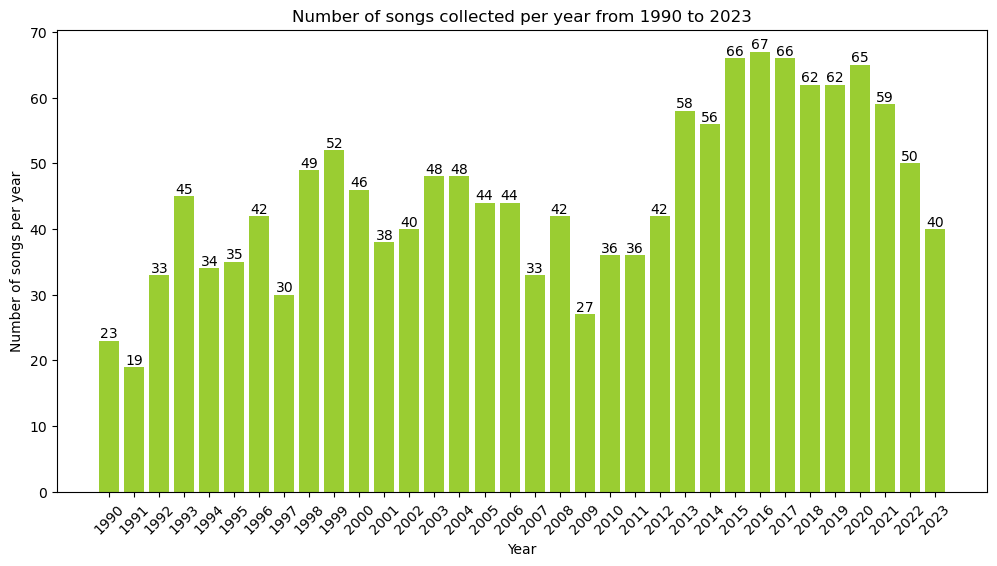

In [92]:
fig, ax = plt.subplots(figsize=(12,6))
years, counts = count_songs_per_year(df)
ax.set_title('Number of songs collected per year from 1990 to 2023')
ax.set_xticks(years,labels=years,rotation=45)
bars = ax.bar(height=counts,x=years,color='yellowgreen')
ax.bar_label(bars, labels=counts)
ax.set_xlabel('Year')
ax.set_ylabel('Number of songs per year')
plt.show()

In [93]:
STEMMER = RSLPStemmer()
TOKERNIZER = RegexpTokenizer(re.compile(r'\w+'))

def clean_lyrics(lyrics: str) -> str:
    lyrics = re.sub('\n+', ' ', lyrics)
    lyrics = lyrics.lower()
    return ' '.join([STEMMER.stem(word) for word in TOKERNIZER.tokenize(lyrics) if word not in STOPWORDS_PORTUGUESE and not re.match(r'\d+', word)])

df['clean_lyrics'] = df['lyrics'].apply(clean_lyrics)

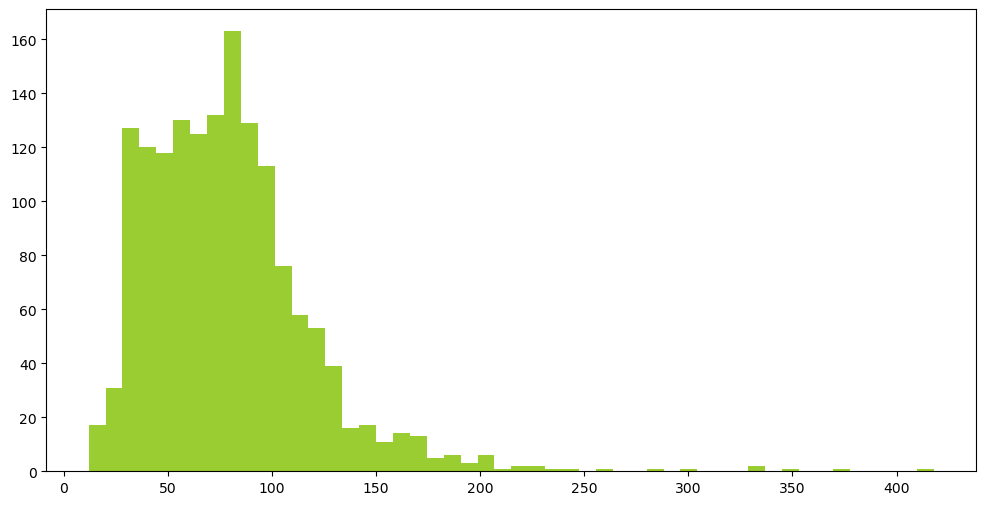

In [94]:
def plot_histogram(series):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.hist(series, bins=50, color='yellowgreen')
    plt.show()

clean_lyrics_len = df['clean_lyrics'].apply(lambda x: len(x.split()))
plot_histogram(clean_lyrics_len)

In [95]:
VECTORIZER = CountVectorizer(max_df=0.9, min_df=0.01)
tf = VECTORIZER.fit_transform(df['clean_lyrics']).toarray()
tf_feature_names = VECTORIZER.get_feature_names_out()
tf.shape

(1537, 636)

In [96]:
var_params = [{'n_components': k, 'doc_topic_prior': 1/k, 'topic_word_prior': 1/k}
               for k in range(3, 20)]

const_params = {
    'max_iter': 100,
    'random_state': 20191122,
}

candidate_models = evaluate_topic_models(data=tf, varying_parameters=var_params, constant_parameters=const_params)

/home/vinicius/miniforge3/envs/txmm/lib/python3.12/site-packages/tmtoolkit/topicmod/visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


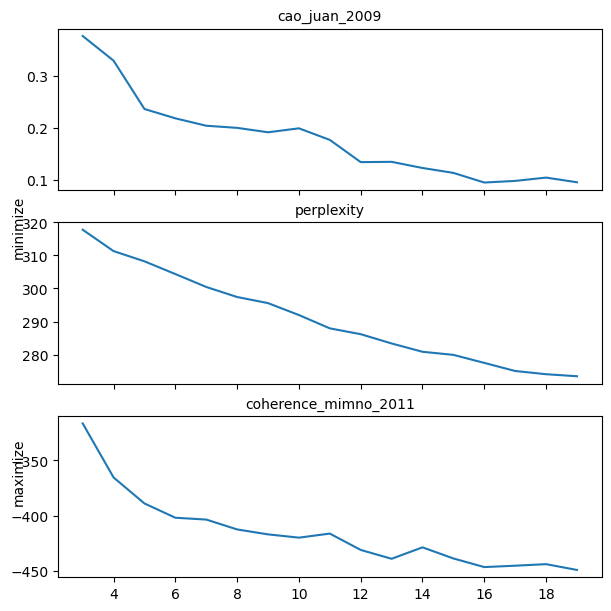

In [97]:
eval_results_by_topics = results_by_parameter(candidate_models, 'n_components')
plot_eval_results(eval_results_by_topics)
plt.show()

In [98]:
sorted(candidate_models, key=lambda x: x[1]['coherence_mimno_2011'], reverse=True)

[({'n_components': 3,
   'doc_topic_prior': 0.3333333333333333,
   'topic_word_prior': 0.3333333333333333,
   'max_iter': 100,
   'random_state': 20191122},
  {'perplexity': 317.80153917617025,
   'cao_juan_2009': 0.3759039162302417,
   'coherence_mimno_2011': -316.5209698014232}),
 ({'n_components': 4,
   'doc_topic_prior': 0.25,
   'topic_word_prior': 0.25,
   'max_iter': 100,
   'random_state': 20191122},
  {'perplexity': 311.31706157410906,
   'cao_juan_2009': 0.32855978333253455,
   'coherence_mimno_2011': -365.35456582243285}),
 ({'n_components': 5,
   'doc_topic_prior': 0.2,
   'topic_word_prior': 0.2,
   'max_iter': 100,
   'random_state': 20191122},
  {'perplexity': 308.22643831615926,
   'cao_juan_2009': 0.23577401978470602,
   'coherence_mimno_2011': -388.82996839287256}),
 ({'n_components': 6,
   'doc_topic_prior': 0.16666666666666666,
   'topic_word_prior': 0.16666666666666666,
   'max_iter': 100,
   'random_state': 20191122},
  {'perplexity': 304.3705971235003,
   'cao_ju

In [99]:
compute_models_parallel(data=tf)

[({}, LatentDirichletAllocation())]

In [100]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

number_of_topics = 5

In [101]:
model_nmf = NMF(n_components=number_of_topics, random_state=0)
model_nmf.fit(tf)
display_topics(model_nmf, tf_feature_names, 10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,am,16.4,mim,4.8,danç,9.1,deix,11.3,vid,7.8
1,coraçã,1.0,gent,4.7,beij,5.0,chor,1.4,lev,4.1
2,lov,0.6,olh,4.5,comig,1.1,fal,1.3,viv,2.9
3,paix,0.6,fic,4.4,boc,1.0,sofr,1.0,deu,2.3
4,beij,0.5,coraçã,4.0,mund,0.7,pens,1.0,feliz,0.8
5,sonh,0.5,pass,3.9,pi,0.7,encontr,0.8,mund,0.6
6,viv,0.5,fal,3.5,dig,0.6,quis,0.7,quer,0.5
7,gent,0.5,volt,2.8,mex,0.5,tom,0.6,esper,0.5
8,sent,0.5,quer,2.2,corp,0.4,paz,0.6,troc,0.4
9,doid,0.5,gost,2.1,águ,0.4,mim,0.6,val,0.4


In [102]:
model_lda = LatentDirichletAllocation(n_components=5, random_state=20191122)
model_lda.fit(tf)
display_topics(model_lda, tf_feature_names, 10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,volt,426.5,gent,523.4,am,3596.9,quer,553.7,danç,419.2
1,beb,412.7,olh,501.5,coraçã,801.0,mim,483.0,gost,347.9
2,saudad,401.5,beij,498.0,viv,656.4,deix,442.2,lev,327.0
3,chor,355.0,tav,227.6,vid,619.2,fal,435.7,comig,299.0
4,deix,353.0,am,224.2,mim,578.2,fic,432.3,deix,226.2
5,cas,311.4,fal,181.8,sonh,448.7,olh,370.3,cheg,225.1
6,sofr,310.7,mund,171.0,gent,384.9,esquec,348.6,namor,189.3
7,pass,300.9,vid,166.5,pass,357.0,pens,293.8,vam,183.2
8,lig,279.1,gost,148.1,fic,353.9,mund,271.5,beij,178.9
9,coraçã,217.3,fic,144.8,sent,343.3,lembr,264.2,mulh,168.8


In [103]:
tf_feature_names

array(['abandon', 'abert', 'abr', 'abraç', 'abrig', 'acab', 'acalm',
       'aceit', 'acend', 'acert', 'ach', 'acompanh', 'acontec', 'acord',
       'acostum', 'acredit', 'adiant', 'ador', 'afast', 'aguent', 'ajud',
       'alegr', 'algum', 'alguém', 'alm', 'alt', 'am', 'ama', 'amanhec',
       'amanhã', 'amarr', 'ame', 'amig', 'amizad', 'amo', 'and', 'anj',
       'antig', 'apag', 'apaixon', 'aparec', 'apert', 'aprend', 'ar',
       'ard', 'are', 'arranc', 'arrepend', 'arrepi', 'arrum', 'asa',
       'assum', 'assunt', 'atend', 'atenç', 'aument', 'avent', 'avis',
       'azul', 'baby', 'baix', 'bal', 'balanç', 'banc', 'band', 'banh',
       'bar', 'bast', 'bat', 'batom', 'beb', 'beij', 'bel', 'bich', 'bob',
       'boc', 'bol', 'bonit', 'bot', 'brasil', 'braç', 'brig', 'brilh',
       'brinc', 'busc', 'cabel', 'cabeç', 'cad', 'café', 'cai', 'cair',
       'cal', 'calm', 'cam', 'caminh', 'cans', 'cant', 'cançã', 'capaz',
       'car', 'carent', 'carnav', 'carr', 'carreg', 'cart', 'cas'

In [104]:
metric_coherence_gensim(measure='u_mass', 
                        top_n=10, 
                        topic_word_distrib=model_lda.components_, 
                        dtm=tf, 
                        vocab=tf_feature_names, 
                        texts=df['clean_lyrics'].values)

[-1.5386279716394777,
 -1.4507897103754153,
 -1.3019286460982757,
 -1.5526654132309592,
 -2.0758634574926167]